# Project Objective

The primary goal of this project is to develop a robust machine learning pipeline. While some feature engineering will be done, the focus is not on extensive feature creation or optimization. Instead, the emphasis is on building an efficient and scalable pipeline that can handle data preprocessing, transformation, and model training in a systematic manner. The project is not about achieving the best possible metrics, but rather ensuring that the pipeline can be easily adapted and deployed for different datasets and machine learning tasks.

This notebook is the first step in the project and serves as an exploratory phase to better understand the dataset. It will help determine the most appropriate feature engineering techniques to apply and guide the decisions on how the data should be processed for subsequent steps in the pipeline.



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ydata_profiling import ProfileReport
import scipy.stats as stats

pd.set_option('display.max_columns', None)

/Users/robertogarces/miniforge3/envs/aus_rain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
df = pd.read_csv('../data/raw/weatherAUS.csv')
target = 'RainTomorrow'
# Drop target labels that are null
df.dropna(subset=[target], inplace=True)
# Convert both target and RainToday feature into boolean
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})

print(f'Dataframe shape: {df.shape}')
df.head(3)

Dataframe shape: (142193, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0


In [3]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday        float64
RainTomorrow       int64
dtype: object

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df[['RainToday', 'RainTomorrow']] = df[['RainToday', 'RainTomorrow']].astype('category')
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()


# Null data analysis

In [14]:
df.isna().mean().sort_values(ascending=False)

Sunshine         0.476929
Evaporation      0.427890
Cloud3pm         0.401525
Cloud9am         0.377353
Pressure9am      0.098556
Pressure3pm      0.098324
WindDir9am       0.070418
WindGustDir      0.065615
WindGustSpeed    0.065193
WindDir3pm       0.026570
Humidity3pm      0.025388
Temp3pm          0.019171
WindSpeed3pm     0.018496
Humidity9am      0.012476
Rainfall         0.009888
RainToday        0.009888
WindSpeed9am     0.009480
Temp9am          0.006358
MinTemp          0.004480
MaxTemp          0.002265
Date             0.000000
Location         0.000000
RainTomorrow     0.000000
dtype: float64

Many features have missing values. In most cases, the amount of missing data is less than 10%, so we'll try to find the most suitable imputation method. However, a few columns have a much higher proportion of missing values, and in those cases, we'll choose to leave them out of the model. 

There may be multiple reasons that explain the existence of so many missing values, especially in the fields `'Sunshine'`, `'Evaporation'`, `'Cloud3pm'`, and `'Cloud9am'`. It is likely due to the fact that in certain locations, these variables are not measured for whatever reason, which would explain the high proportion of missing data.

In [25]:
features_with_many_nulls = ["Sunshine", "Evaporation", "Cloud3pm", "Cloud9am"]

def check_nulls_by_feature(df, features, group_by='Location'):
    for feature in features:
        grouped = df.groupby(group_by)[feature].apply(lambda x: x.isnull().mean()).sort_values(ascending=False)
        print(f"\nNull % of feature {feature} grouped by {group_by} \n{grouped}")

check_nulls_by_feature(df, features_with_many_nulls)


Null % of feature Sunshine grouped by Location 
Location
Newcastle           1.000000
Walpole             1.000000
NorahHead           1.000000
Penrith             1.000000
Richmond            1.000000
SalmonGums          1.000000
Launceston          1.000000
Katherine           1.000000
Tuggeranong         1.000000
GoldCoast           1.000000
Uluru               1.000000
Nhil                1.000000
MountGinini         1.000000
Witchcliffe         1.000000
Bendigo             1.000000
Ballarat            1.000000
BadgerysCreek       1.000000
Wollongong          1.000000
Albury              1.000000
Cobar               0.815930
Canberra            0.557636
CoffsHarbour        0.495090
Williamtown         0.470819
Adelaide            0.450485
Sale                0.394000
Woomera             0.330100
Moree               0.280659
AliceSprings        0.168591
Albany              0.167772
Dartmoor            0.150187
Portland            0.147196
MountGambier        0.142904
Cairns        

What’s actually happening is that in many locations, the fields we’re analyzing simply aren’t measured. We’ll analyze the distribution and ranges of these features to determine the best way to impute the missing values.

In [27]:
df[features_with_many_nulls].describe()

,Sunshine,Evaporation,Cloud3pm,Cloud9am
count,74377.000000,81350.000000,85099.000000,88536.000000
mean,7.624853,5.469824,4.503167,4.437189
std,3.781525,4.188537,2.720633,2.887016
min,0.000000,0.000000,0.000000,0.000000
25%,4.900000,2.600000,2.000000,1.000000
50%,8.500000,4.800000,5.000000,5.000000
75%,10.600000,7.400000,7.000000,7.000000
max,14.500000,145.000000,9.000000,9.000000


We can see that all the values for these features are positive, so we’ll impute the missing values using the median, grouped by month and location. If there are no available data for a given location, we’ll use -1 as a fallback. This approach allows us to clearly distinguish between actual and imputed values, and it works well with tree-based models like Random Forest and XGBoost.

# Profile Report

In [6]:
#ProfileReport(df)

# Display the distribution of the numerical features

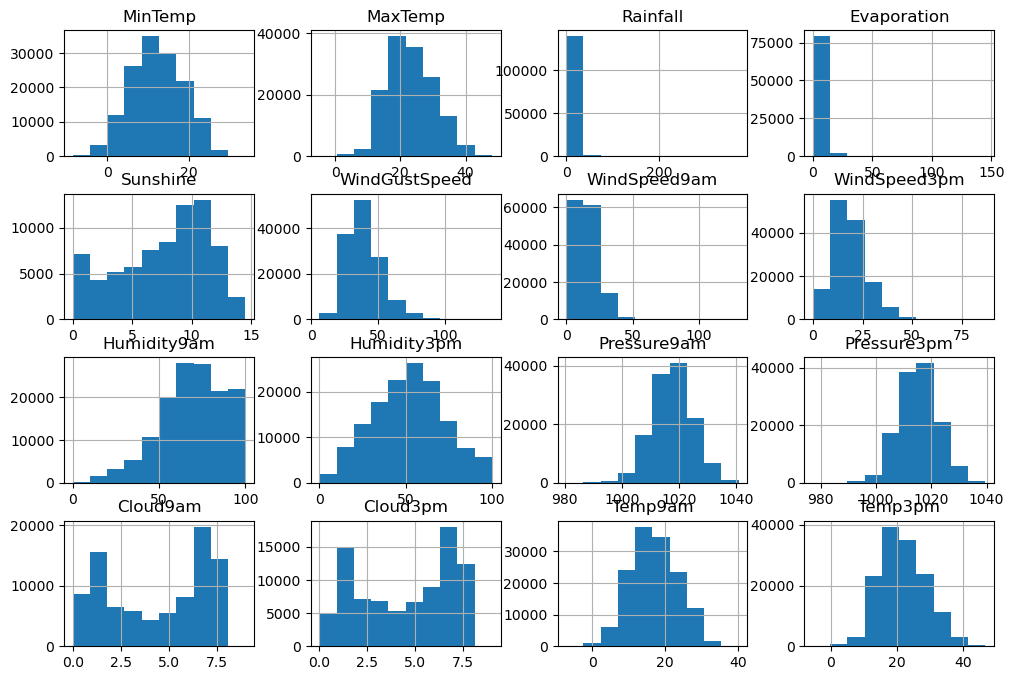

In [7]:
df[numerical_features].hist(figsize=(12, 8))
plt.show()
features_with_outliers = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']

In [8]:
skew_values = df[numerical_features].skew(numeric_only=True).sort_values()
print(skew_values)

Sunshine        -0.502911
Humidity9am     -0.482821
Cloud9am        -0.224286
Cloud3pm        -0.224092
Pressure9am     -0.096211
Pressure3pm     -0.046198
MinTemp          0.023900
Humidity3pm      0.034515
Temp9am          0.091387
MaxTemp          0.224917
Temp3pm          0.240054
WindSpeed3pm     0.631433
WindSpeed9am     0.775494
WindGustSpeed    0.874305
Evaporation      3.746834
Rainfall         9.888061
dtype: float64


Based on the histograms, we can identify several variables that contain outliers, particularly in features like Rainfall, Evaporation and WindGustSpeed. These extreme values are likely to distort the analysis and model performance, so they will be removed from the dataset.

Regarding the distributions, many variables such as MinTemp, MaxTemp, Temperature9am, and Temperature3pm show relatively symmetric or normal-like shapes, which is favorable for most machine learning algorithms. On the other hand, some features like Humidity9am, Sunshine, and Cloud9am appear to be skewed or unevenly distributed. Anyways we will not deal with this in the first instance since our first approach will be to build a tree-based model.

# Display the frequency of each value in categorical variables

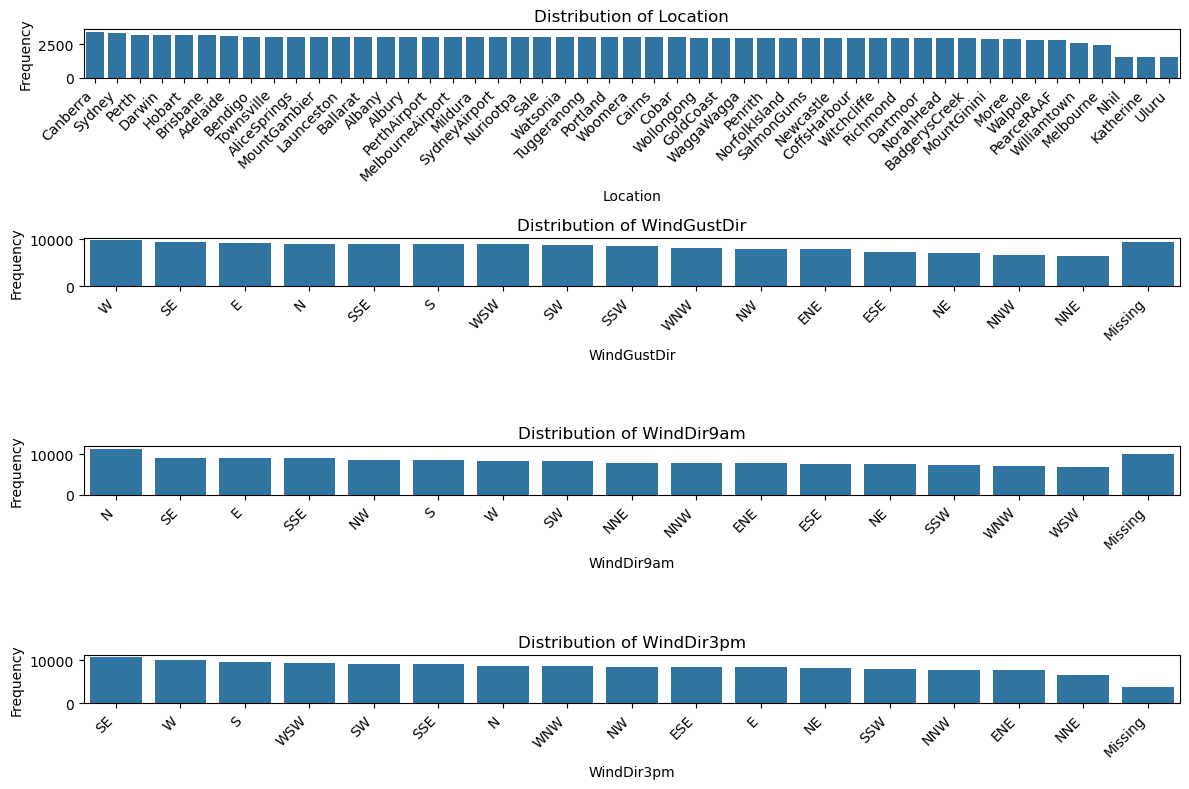

In [9]:
plt.figure(figsize=(12, 8))

for idx, feature in enumerate(categorical_features):
    plt.subplot(len(categorical_features), 1, idx+1)  # Create a subplot for each categorical variable
    # Create a temporary copy for visualization
    temp_feature = df[feature].copy()
    # Replace nulls with "Missing" only in the temporary copy
    temp_feature = temp_feature.fillna("Missing")
    
    # Get the order of categories
    category_order = [cat for cat in temp_feature.value_counts().index if cat != "Missing"]
    
    # Append "Missing" only if there are missing values
    if temp_feature.isin(["Missing"]).any():
        category_order.append("Missing")
    
    # Create the plot with the specified order
    sns.countplot(x=temp_feature, order=category_order)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels 45 degrees
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


From these frequency plots, we can see that there is no high cardinality and that the categories of each feature are distributed almost uniformly, except for one particular case. Therefore, we can consider these features clean and decide not to preprocess them before encoding.

# Features correlation with target feature

In [10]:
# Cramér's V calculation function
def cramers_v(x, y):
    # Create a contingency table
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, ex = stats.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Main function to display the correlation between categorical features
def categorical_correlation(df, categorical_features, target):

 #   df['target_categorical'] = pd.cut(df[target], bins=5, labels=False, include_lowest=True)

    # Lista para almacenar los resultados de Cramér's V
    cramers_v_matrix = []

    # Iterar sobre las variables categóricas
    for feature in categorical_features:
        # Calcular la correlación entre la variable categórica y la variable target categorizada
        cramers_v_val = cramers_v(df[feature], df[target])
        cramers_v_matrix.append([feature, target, cramers_v_val])
    
    # Convertir el resultado en un DataFrame
    cramers_v_df = pd.DataFrame(cramers_v_matrix, columns=['Feature', 'Target', 'Cramérs V'])
    
    # Eliminar la columna temporal 'target_categorical'
   # df.drop(columns=[target], inplace=True)

    return cramers_v_df

# Calcular la matriz de correlación
correlation_matrix = categorical_correlation(df, categorical_features, target)

# Mostrar el resultado
print(correlation_matrix.sort_values(by='Cramérs V', ascending=False))

       Feature        Target  Cramérs V
0     Location  RainTomorrow   0.157891
2   WindDir9am  RainTomorrow   0.129446
1  WindGustDir  RainTomorrow   0.106956
3   WindDir3pm  RainTomorrow   0.096212


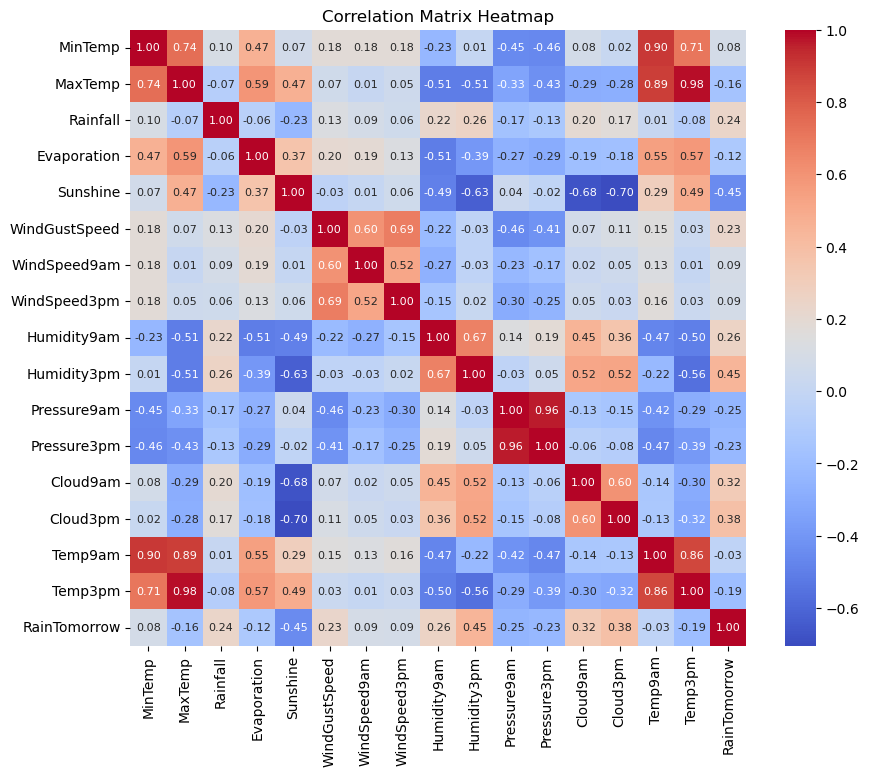

In [11]:
# Calculate correlation matrix
df['RainTomorrow'] = df['RainTomorrow'].astype(int)
numerical_features.append('RainTomorrow')
corr_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, annot_kws={"fontsize":8})
plt.title("Correlation Matrix Heatmap")
plt.show()

numerical_features.remove('RainTomorrow')
df['RainTomorrow'] = df['RainTomorrow'].astype('category')

From the correlation matrix, we observe that some variables exhibit varying degrees of correlation with the target variable (rain_tomorrow). While correlation provides a useful initial insight, it primarily captures linear relationships and may miss more complex patterns. Therefore, instead of outright removing features with low correlation, we will complement this analysis with feature selection methods based on model explainability techniques, such as feature importance scores or SHAP values.

Additionally, several variables show high correlation among themselves. To address multicollinearity, we will select only one variable from each highly correlated group—preferably the one with the fewest missing values—to include in the model.


# Distribution of numerical features depending on target

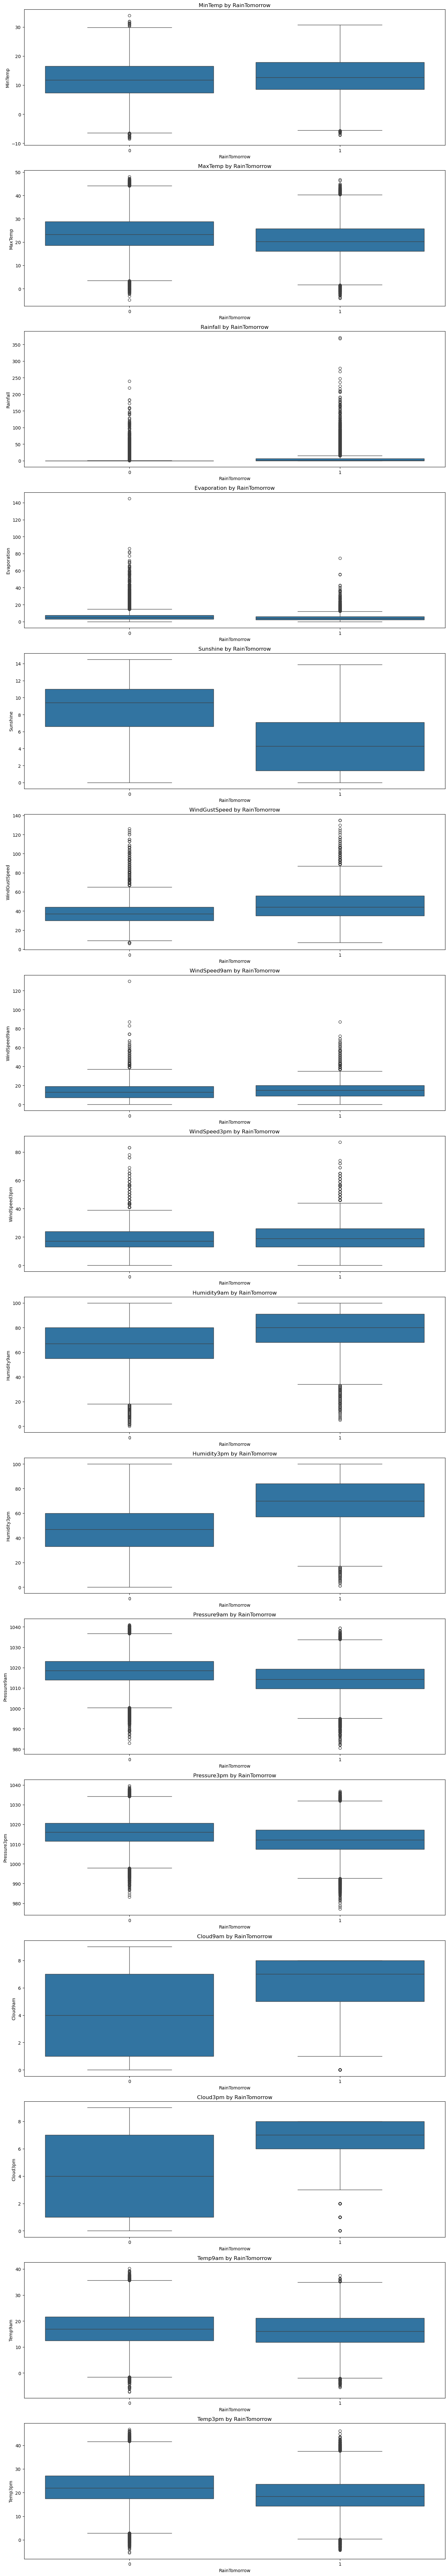

In [12]:
# Crear un boxplot por cada feature numérica
plt.figure(figsize=(14, 5 * len(numerical_features)))

for idx, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 1, idx + 1)
    sns.boxplot(x='RainTomorrow', y=feature, data=df)
    plt.title(f'{feature} by RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


We can observe that most numerical features display differences in their distributions depending on whether it will rain tomorrow or not. This suggests that these features carry predictive information, which can be beneficial for the model's performance.

# Rain frequency per month

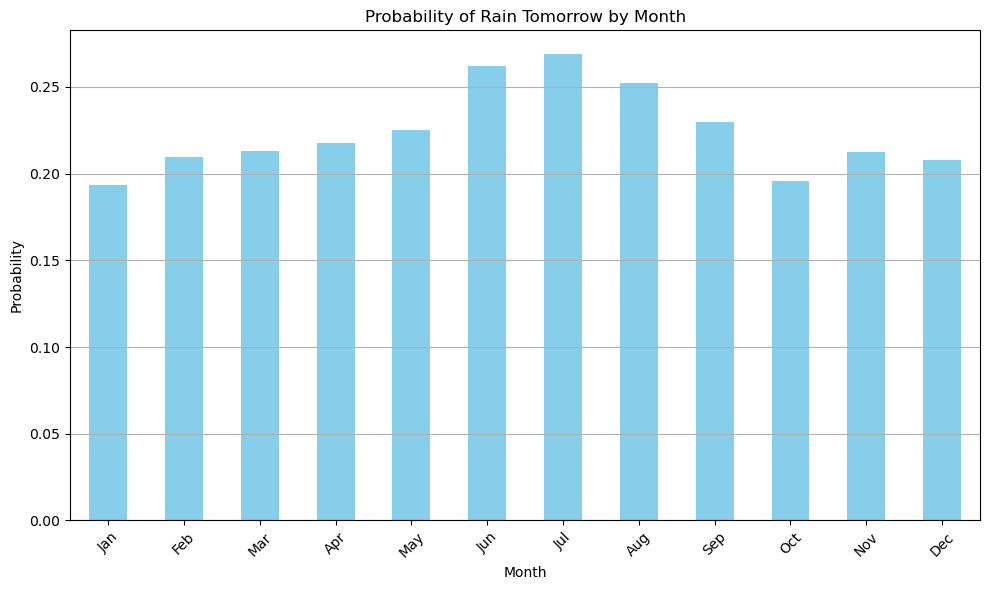

In [13]:
# Extract the month from the date
df['Month'] = df['Date'].dt.month
df['RainTomorrow'] = df['RainTomorrow'].astype(int)

# Group by month and calculate mean (probability of rain)
monthly_rain_prob = df.groupby('Month')['RainTomorrow'].mean()

# Plot the monthly probability of rain
plt.figure(figsize=(10, 6))
monthly_rain_prob.plot(kind='bar', color='skyblue')
plt.title('Probability of Rain Tomorrow by Month')
plt.xlabel('Month')
plt.ylabel('Probability')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



An analysis of monthly rainfall patterns reveals a clear seasonal trend. Specifically, the probability of rainfall increases noticeably during the months of June through September. This suggests that rainfall in Australia tends to be more frequent in the winter and early spring months, which aligns with known seasonal weather patterns in many regions of the country.

This trend is potentially useful for modeling, as the month of the year could serve as a valuable predictor. Including this temporal feature may help the model capture seasonal effects, which could improve its ability to predict rainfall events more accurately. Further analysis could be performed at a more granular level, such as evaluating rainfall trends by region or incorporating weather season categories (e.g., summer, autumn), to enhance this insight.

---

## 📌 Feature Engineering Plan

Based on the exploratory data analysis (EDA) conducted, we can now outline a structured plan to guide the feature engineering process. The following steps will be followed:

1. **Create a `'Month'` Feature**  
   Extract the month from the date column to capture potential seasonal trends in rainfall.

2. **Remove Outliers**  
   Identify and eliminate extreme values that may distort the model’s performance.

3. **Address Skewness**  
   Apply transformations (e.g., log, Box-Cox) to reduce skewness in numerical features where necessary.

4. **Remove Highly Correlated Features**  
   Drop redundant features that show strong correlation with each other to reduce multicollinearity.

5. **Handle Missing Values**  
   - If a feature has a high percentage of missing values, it will either be dropped or a new category such as `'Missing'` will be created (for categorical features).  
   - If the percentage of missing values is moderate or low, different imputation strategies will be tested.

6. **Create New Features**  
   Engineer additional features based on domain knowledge or variable interactions that may improve model performance.

7. **Standardization and Encoding**  
   - Standardize numerical features to ensure consistent scale.  
   - Apply suitable encoding techniques (e.g., One-Hot Encoding, Ordinal Encoding) to categorical features for compatibility with machine learning algorithms.

# HACER ANALISIS DE NULOSSSSS (EJ: EN ULURU NO SE MIDE EVAPORATION)